# Team Members:
- Amir Mobayen
- Leelav Kareem
- Nikita Chistyakov

## Topic:
A fine-tuned version of distilbert-base-uncased model on the emotion dataset (from HF)

## Libraries

In [1]:
# @title
# Transformer packages
!pip install transformers
!pip install xformers
!pip install torch

# Basic packages
import numpy as np
import pandas as pd

# Plots
import matplotlib.pyplot as plt

# Tensorflow
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import pad_sequences

# Sklearn
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

tf.get_logger().setLevel('ERROR')

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 14.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 18.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 24.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 24.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.1/109.1 MB 8.8 MB/s eta 0:00:00


# About the dataset:
List of tweet texts with emotion labels like joy, sadness, fear, anger…
Dataset is split into train, test and validation sets for building the machine learning model. At first, you are
given only train and test sets. The validation one will be given in the end of the project for you to check
the final performance of your algorithm (to make sure there is no overfitting over the test data).

# Model 3 Goal:
- Use bert pre-trained embeddings (from huggingface) and train a NN on top of those
- Enable classification of each text according to the sentiment mainly present
in it
- Compare the results of your different models and try to analyze and explain the differences

# Parameters

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
# Define the path to the data and test file directory
data_file = '/content/drive/MyDrive/*NLP/NLP_exam_emotions_dataset/train.txt'
test_file = '/content/drive/MyDrive/*NLP/NLP_exam_emotions_dataset/test.txt'

max_len = 128  # Maximum sequence length for BERT

In [8]:
# Read train data
train_data = pd.read_csv(data_file, delimiter=';', header=None)
train_data.columns = ['comments', 'feeling']

# Read test data
test_data = pd.read_csv(test_file, delimiter=';', header=None)
test_data.columns = ['comments', 'feeling']

train_data.head()
test_data.head()

,comments,feeling
0,im feeling rather rotten so im not very ambiti...,sadness
1,im updating my blog because i feel shitty,sadness
2,i never make her separate from me because i do...,sadness
3,i left with my bouquet of red and yellow tulip...,joy
4,i was feeling a little vain when i did this one,sadness


In [ ]:
# @title
# Alt way to read and preview top 10 rows of the files
def preview_file_top_10_rows(file_path):
    with open(file_path, 'r') as file:
        for _ in range(10):  # Read and print the first 10 lines
            line = file.readline()
            print(line.strip())  # Strip newline character to avoid double spacing

# Preview the top 10 rows of the data_file
print("Contents of data file (top 10 rows):")
preview_file_top_10_rows(data_file)

# Preview the top 10 rows of the test_file
print("\nContents of test file (top 10 rows):")
preview_file_top_10_rows(test_file)

Contents of data file (top 10 rows):
i didnt feel humiliated;sadness
i can go from feeling so hopeless to so damned hopeful just from being around someone who cares and is awake;sadness
im grabbing a minute to post i feel greedy wrong;anger
i am ever feeling nostalgic about the fireplace i will know that it is still on the property;love
i am feeling grouchy;anger
ive been feeling a little burdened lately wasnt sure why that was;sadness
ive been taking or milligrams or times recommended amount and ive fallen asleep a lot faster but i also feel like so funny;surprise
i feel as confused about life as a teenager or as jaded as a year old man;fear
i have been with petronas for years i feel that petronas has performed well and made a huge profit;joy
i feel romantic too;love

Contents of test file (top 10 rows):
im feeling rather rotten so im not very ambitious right now;sadness
im updating my blog because i feel shitty;sadness
i never make her separate from me because i don t ever want her t

# Explore and Prepare dataset

In [9]:
train_data = pd.read_csv(data_file, delimiter=';', header=0)
test_data = pd.read_csv(test_file, delimiter=';', header=0)

train_data.head(), test_data.head()

(                             i didnt feel humiliated  sadness
 0  i can go from feeling so hopeless to so damned...  sadness
 1   im grabbing a minute to post i feel greedy wrong    anger
 2  i am ever feeling nostalgic about the fireplac...     love
 3                               i am feeling grouchy    anger
 4  ive been feeling a little burdened lately wasn...  sadness,
   im feeling rather rotten so im not very ambitious right now  sadness
 0          im updating my blog because i feel shitty           sadness
 1  i never make her separate from me because i do...           sadness
 2  i left with my bouquet of red and yellow tulip...               joy
 3    i was feeling a little vain when i did this one           sadness
 4  i cant walk into a shop anywhere where i do no...              fear)

In [10]:
train_data.info(), test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15999 entries, 0 to 15998
Data columns (total 2 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   i didnt feel humiliated  15999 non-null  object
 1   sadness                  15999 non-null  object
dtypes: object(2)
memory usage: 250.1+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1999 entries, 0 to 1998
Data columns (total 2 columns):
 #   Column                                                       Non-Null Count  Dtype 
---  ------                                                       --------------  ----- 
 0   im feeling rather rotten so im not very ambitious right now  1999 non-null   object
 1   sadness                                                      1999 non-null   object
dtypes: object(2)
memory usage: 31.4+ KB


(None, None)

In [11]:
# @title
# Check the number of classes in the second column of train_data
num_classes_train = train_data.iloc[:, 1].nunique()

# Check the number of classes in the second column of test_data
num_classes_test = test_data.iloc[:, 1].nunique()

print("Number of classes in train_data:", num_classes_train)
print("Number of classes in test_data:", num_classes_test)

Number of classes in train_data: 6
Number of classes in test_data: 6


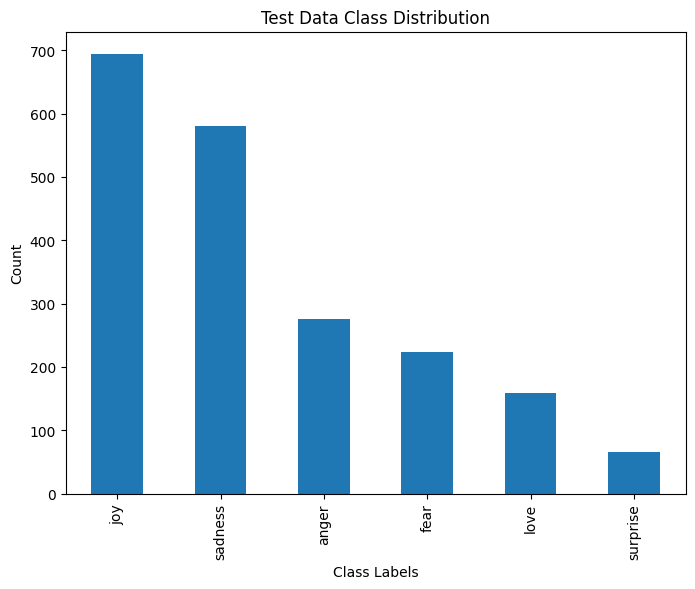

In [12]:
# Plot the distribution of classes in the test data
plt.figure(figsize=(8, 6))
test_data.iloc[:, 1].value_counts().plot(kind='bar')
plt.xlabel('Class Labels')
plt.ylabel('Count')
plt.title('Test Data Class Distribution')
plt.show()

#### Preparing text data before feeding it into a machine learning model

In [53]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

In [54]:
# Preprocess the data
def preprocess_text(text, tokenizer, max_len):
    input_ids = tokenizer.encode(text, add_special_tokens=True, truncation=True, max_length=max_len, padding='max_length')
    return input_ids

In [55]:
train_input_ids_list = [preprocess_text(text, tokenizer, max_len) for text in train_data.iloc[:, 0]]
train_input_ids_batch = tf.convert_to_tensor(train_input_ids_list)
train_labels = tf.convert_to_tensor(train_data.iloc[:, 1])
len_label = len(np.unique(train_labels))

test_input_ids_list = [preprocess_text(text, tokenizer, max_len) for text in test_data.iloc[:, 0]]
test_input_ids_batch = tf.convert_to_tensor(test_input_ids_list)
test_labels = tf.convert_to_tensor(test_data.iloc[:, 1])

In [59]:
# Label Encoder
label_encoder = LabelEncoder()
train_y = label_encoder.fit_transform(train_data.iloc[:, 1])
test_y = label_encoder.transform(test_data.iloc[:, 1])

# Model 3 (Bert from HF)

In [ ]:
import tensorflow as tf
from transformers import BertTokenizer, TFBertModel
import pandas as pd

# Load the pre-trained BERT model and tokenizer
model_name = 'bert-base-uncased'
tokenizer = BertTokenizer.from_pretrained(model_name)
bert_model = TFBertModel.from_pretrained(model_name)

# Load your own data
train_data = pd.read_csv(data_file, delimiter=';', header=None)
train_data.columns = ['comments', 'feeling']

# Tokenize and encode the text data for training
train_texts = train_data['comments'].tolist()
train_encodings = tokenizer(train_texts, truncation=True, padding=True, return_tensors='tf')
train_labels = train_data['feeling'].tolist()

# Convert labels to tensors
train_labels = tf.convert_to_tensor(train_labels)

# Freeze all layers of the pre-trained model
for layer in bert_model.layers:
    layer.trainable = False

# Get the output of the last layer of the BERT model
input_ids = train_encodings['input_ids']
attention_mask = train_encodings['attention_mask']
bert_output = bert_model(input_ids, attention_mask=attention_mask)[0]

# Classification layers on top of BERT
classifier = tf.keras.Sequential([
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Compile the model
classifier.compile(optimizer='adam',
                   loss='binary_crossentropy',
                   metrics=['accuracy'])

# Fine-tune the classifier
num_epochs = 5
batch_size = 32
classifier.fit(bert_output, train_labels, batch_size=batch_size, epochs=num_epochs)

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

In [76]:
from transformers import BertTokenizer, TFAutoModelForSequenceClassification

# Load pre-trained BERT model
model = TFAutoModelForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=len_label)

# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=2e-5),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

model.summary

All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


<bound method Model.summary of <transformers.models.bert.modeling_tf_bert.TFBertForSequenceClassification object at 0x7bdd014ec6d0>>

In [78]:
# Train the model
history = model.fit(train_input_ids_batch, train_y, epochs=5, batch_size=64)

Epoch 1/5
250/250 [==============================] - 12477s 50s/step - loss: 0.8185 - accuracy: 0.7134
Epoch 2/5
 29/250 [==>...........................] - ETA: 3:01:55 - loss: 0.2345 - accuracy: 0.9213

KeyboardInterrupt: ignored

# It takes long times. and also we faced many crashes on it with google colab and local computers. so we decided to cancle it here in order to prevent from future crashes.

# Evaluation

In [80]:
import numpy as np
from sklearn.metrics import accuracy_score, classification_report

In [81]:
# Evaluate the model
predicted_class_indices = np.argmax(model.predict(test_input_ids_batch)[0], axis=1)
predicted_labels = label_encoder.inverse_transform(predicted_class_indices)
accuracy = accuracy_score(test_data.iloc[:, 1], predicted_labels)
print(f'Test Accuracy: {accuracy:.4f}')

print('Classification Report:')
print(classification_report(test_data.iloc[:, 1], predicted_labels))

63/63 [==============================] - 507s 8s/step
Test Accuracy: 0.9165
Classification Report:
              precision    recall  f1-score   support

       anger       0.93      0.89      0.91       275
        fear       0.85      0.95      0.90       224
         joy       0.92      0.96      0.94       695
        love       0.85      0.79      0.82       159
     sadness       0.95      0.95      0.95       580
    surprise       0.95      0.53      0.68        66

    accuracy                           0.92      1999
   macro avg       0.91      0.84      0.86      1999
weighted avg       0.92      0.92      0.91      1999



# Sample Test

In [83]:
# Load "Real-Cases" data and test file directory
real_case_complete = '/content/drive/MyDrive/*NLP/NLP_exam_real_case_dataset/complete.csv'
real_case_test = '/content/drive/MyDrive/*NLP/NLP_exam_real_case_dataset/test.csv'
real_case_train = '/content/drive/MyDrive/*NLP/NLP_exam_real_case_dataset/train.csv'

In [ ]:
# @title
# Read and preview top 10 rows of the files
def preview_file_top_10_rows(file_path):
    with open(file_path, 'r') as file:
        for _ in range(10):  # Read and print the first 10 lines
            line = file.readline()
            print(line.strip())  # Strip newline character to avoid double-spacing

# Preview the top 10 rows of the data_file
print("Contents of data file (top 10 rows):")
preview_file_top_10_rows(real_case_complete)

# Preview the top 10 rows of the test_file
print("\nContents of test file (top 10 rows):")
preview_file_top_10_rows(real_case_test)

# Preview the top 10 rows of the train_file
print("\nContents of test file (top 10 rows):")
preview_file_top_10_rows(real_case_train)

Contents of data file (top 10 rows):
,article_title,is_ecology
321,Stations essence à Saint-Jean-Trolimon : les meilleurs prix près de chez moi aujourd'hui,0
414,"Toulouse : Après une embrouille, il percute une voiture avant de tirer sur ses occupants et prendre la fuite",0
2104,"Kopp Johnson, l'auteur de ""Gilet Jaune"", revient avec un nouveau son sur la réforme des retraites",0
699,Brésil : Carlo Ancelotti aurait dit oui à la Seleçao,0
1279,"IBS of Provence, cette école internationale qui séduit les familles d'expatriés",0
146,Faut-il faciliter l’installation de nouvelles centrales nucléaires en France ?,1
1709,Marseille : FO peut-il perdre la main sur la ville,0
2059,Centres de santé bon marché : les députés votent une loi pour lutter contre les abus,0
818,"À Saint-Avé, le concert « La grande folie » a fait salle comble",0

Contents of test file (top 10 rows):
,article_title,is_ecology
56,"Plan de sortie de flotte: seules sept demandes de navires boulonnais ont été validées, un ""s

In [84]:
real_case_train_df = pd.read_csv(real_case_train)

real_case_train_df.head()

,Unnamed: 0,article_title,is_ecology
0,1079,Stations essence à Rochefort-en-Terre : les me...,0
1,1515,"À Brest, le chantier de La Boussole se fait at...",0
2,51,Météorite en Normandie : à la recherche de pré...,0
3,1419,Résultats trimestriels mitigés pour les géants...,0
4,2181,Opinion | Sobriété énergétique : les solutions...,1


Although validating data set by sampling and visualizing is also faced a lot problem on our systems.